In [24]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import matplotlib.pyplot as plt

from protein_search_evals.datasets.radicalsam import RadicalSamDataset

# Sequence length distribution

In [26]:
def plot_histogram(
    data: list[float] | list[int],
    xlabel: str,
    ylabel: str,
    title: str = '',
    bins: int | None = None,
    save_path: str | None = None,
) -> None:
    """Plot a histogram with automatically computed number of bins.

    Parameters
    ----------
    data : list[float] | list[int]
        Data to plot in the histogram.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    title : str, optional
        Title of the plot, by default "" (no title).
    bins : int | None, optional
        The number of bins to use.
    save_path : str | None, optional
        If provided, saves the figure to the given path, by default None.

    Returns
    -------
    None
    """
    # High-quality publication settings
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update(
        {
            'font.family': 'serif',
            'font.size': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'figure.dpi': 300,
        },
    )

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the histogram
    ax.hist(data, bins=bins, color='steelblue', edgecolor='black', alpha=0.7)

    # Customize the plot
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title:
        ax.set_title(title)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Optimize layout
    plt.tight_layout()

    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [27]:
data_dir = '../../data/radicalsam'
sequences = RadicalSamDataset(data_dir, partition='all').load_sequences()

Loading Radical SAM sequences from ../../data/radicalsam/all/sequences.fasta


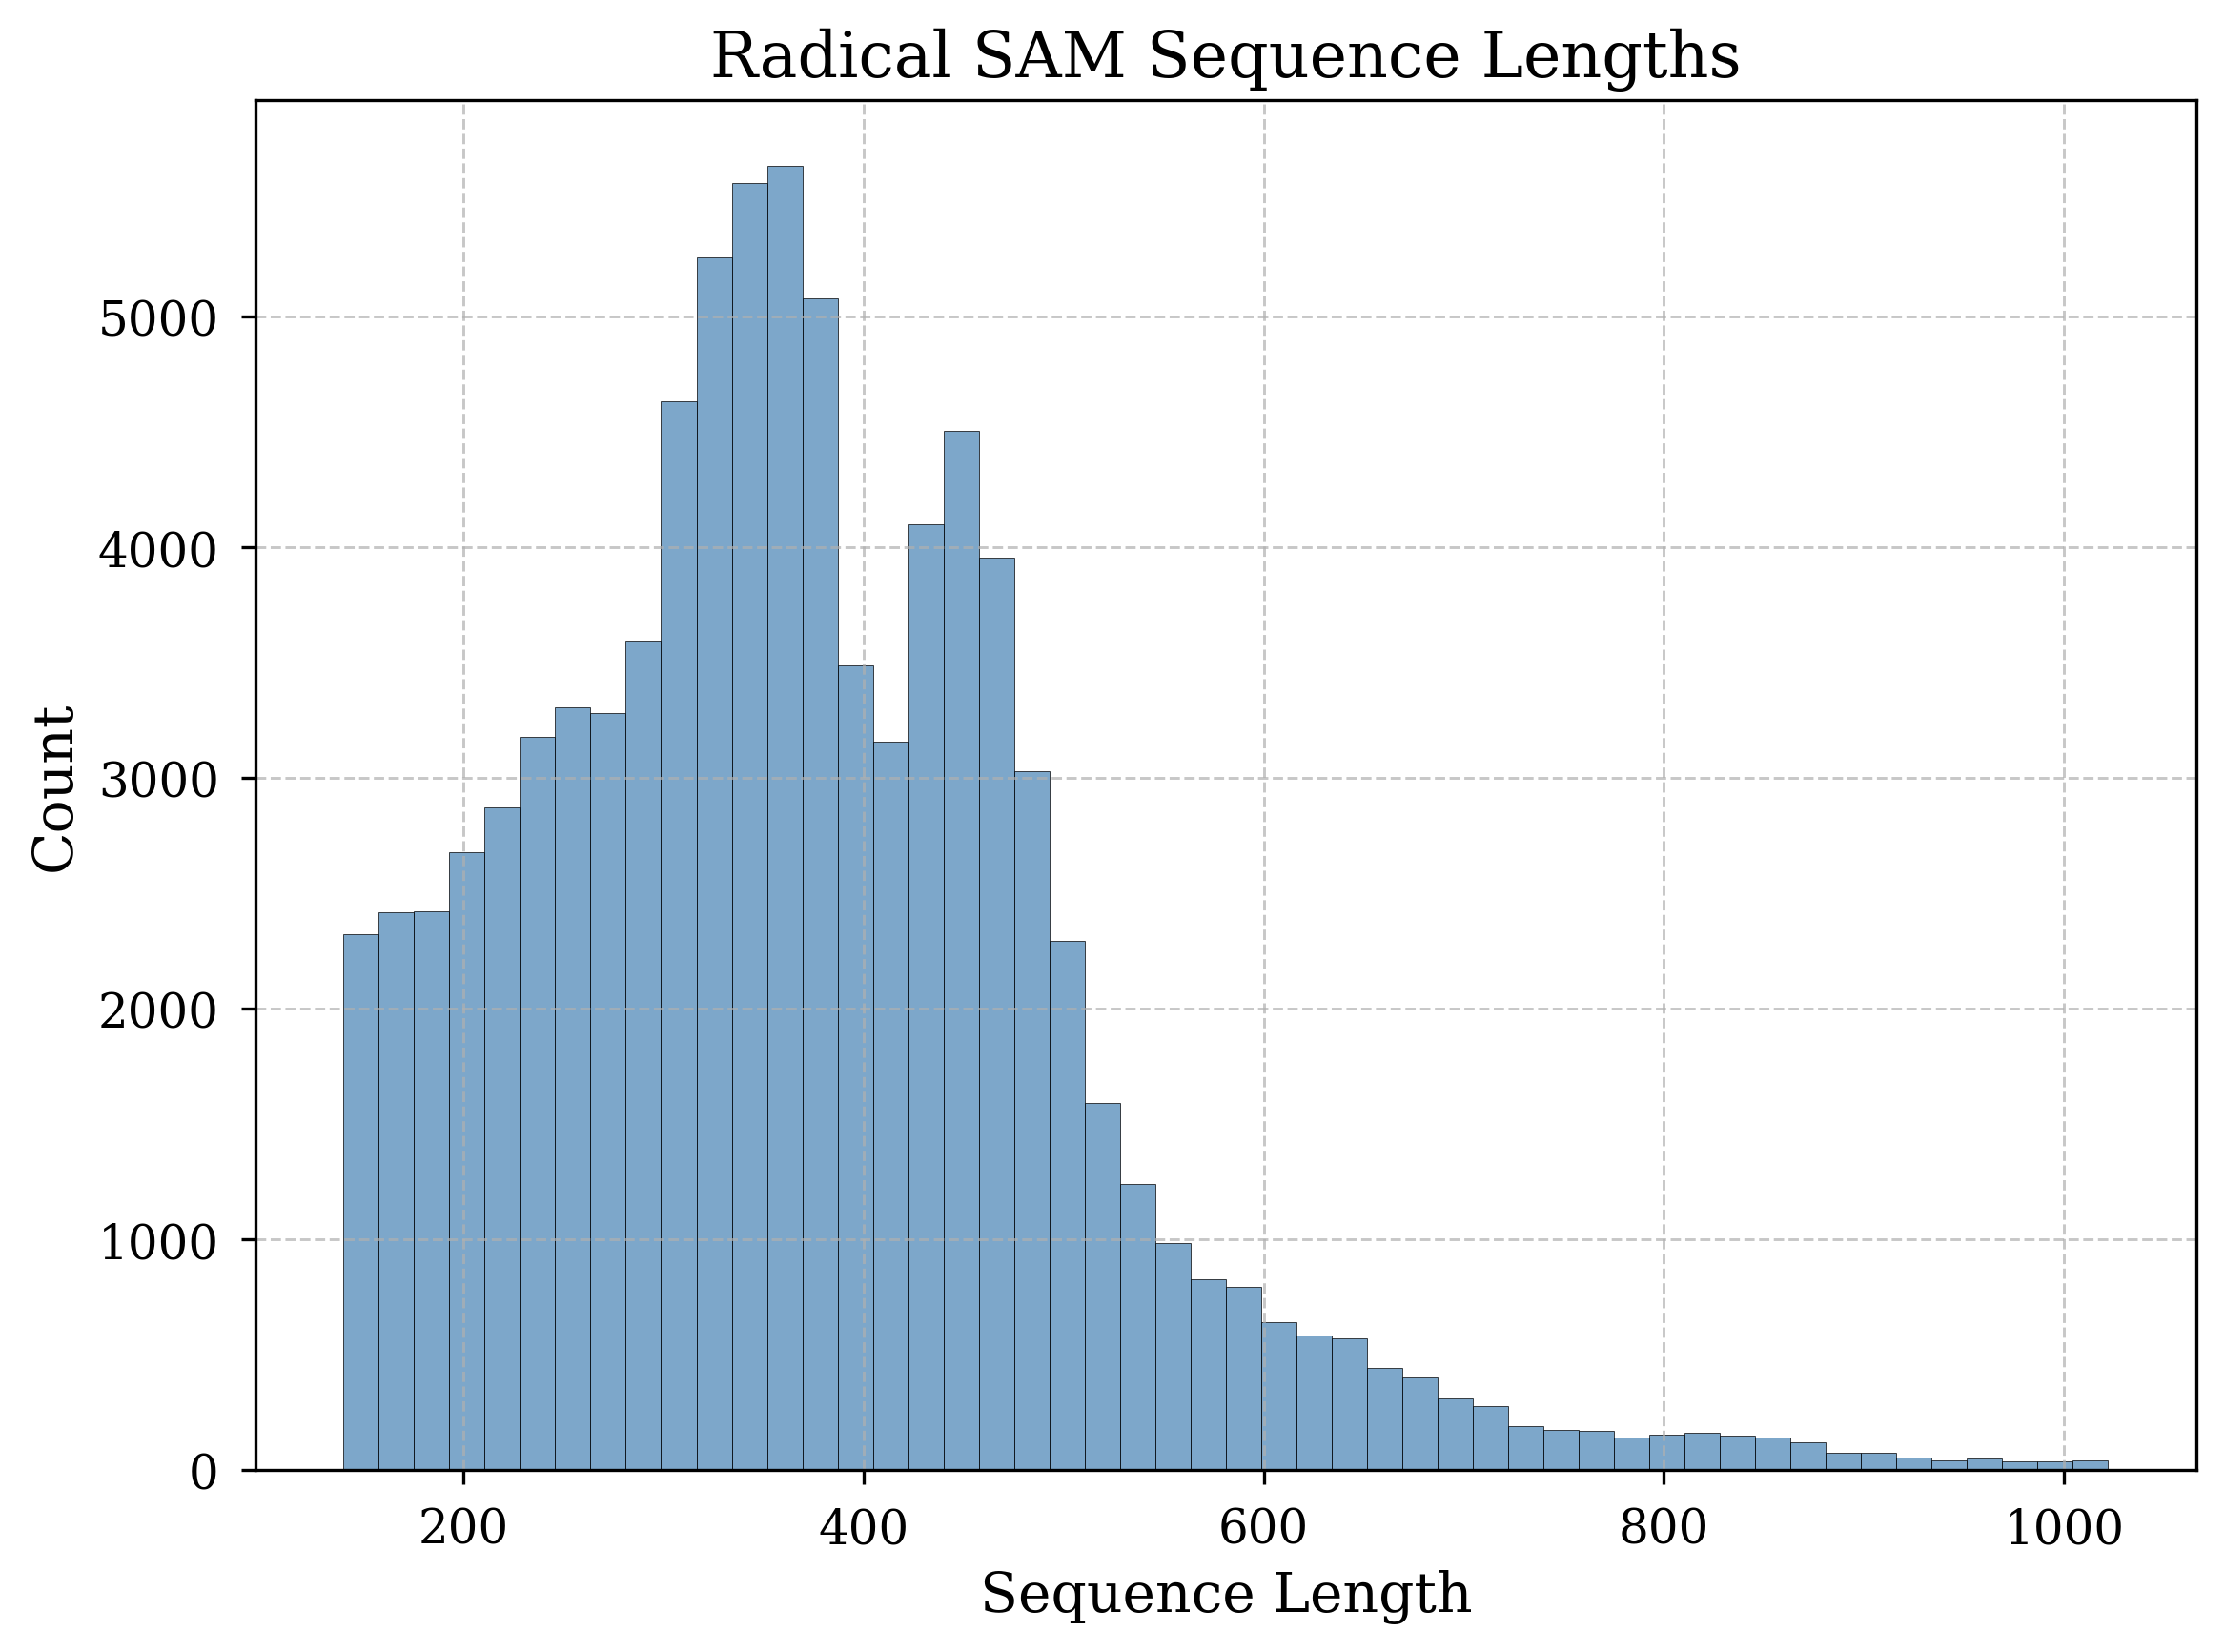

In [28]:
# Plot the sequence lengths
lengths = [len(x.sequence) for x in sequences]

plot_histogram(
    data=lengths,
    xlabel='Sequence Length',
    ylabel='Count',
    title='Radical SAM Sequence Lengths',
    bins=50,
)